In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
from make_datasets import dollarsign
from sklearn.datasets import make_swiss_roll
from clustering import DiffusionGeometrySpectralClustering
from metric import acc
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

## Sensitivity Analysis

In [3]:
X_list = []
y_list = []

n_tests = 10

np.random.seed(42)
for i in range(n_tests):
    ## generate dollar shape
    Xd, Y, labels_d = dollarsign(n_points=1200,seed=42+i)
    ## generate swiss roll 
    Xs, ts = make_swiss_roll(n_samples=600,random_state=42+i)
    x = Xs[:, 0]
    x_scaled = 2*(x - x.min()) / (x.max() - x.min()) + 2
    Xs[:, 0] = x_scaled
    y = Xs[:, 1]
    y_scaled = (y - y.min()) / (y.max() - y.min())
    Xs[:, 1] = y_scaled
    z = Xs[:, 2]
    z_scaled = 4 * (z - z.min()) / (z.max() - z.min()) - 2
    Xs[:, 2] = z_scaled
    ## make whole point cloud and shuffle
    X = np.vstack((Xd, Xs))
    y = np.concatenate([labels_d,np.ones(Xs.shape[0])*2])
    perm = np.random.permutation(X.shape[0])
    X = X[perm]
    y = y[perm]
    
    X_list.append(X)
    y_list.append(y)

In [4]:
## M
mean_acc_list = []
best_acc_list = []
for Ms in range(5,105,5):
    acc_list = []
    for i in range(n_tests):
        y_pred = DiffusionGeometrySpectralClustering(X_list[i],3,M = Ms, K = 36, o = 4, random_state = 42)
        acc_list.append(acc(y_pred, y_list[i]))
    mean_acc_list.append(np.mean(acc_list))
    best_acc_list.append(np.max(acc_list))

Spectral Clustering: 100%|███████████████████████████████████████████████████████████████| 4/4 [00:19<00:00,  4.87s/it]


In [5]:
mean_acc_plot = {}
mean_acc_plot['M'] = mean_acc_list
best_acc_plot = {}
best_acc_plot['M'] = best_acc_list

In [6]:
## K
mean_acc_list = []
best_acc_list = []
for Ks in range(4,40,2):
    acc_list = []
    for i in range(n_tests):
        y_pred = DiffusionGeometrySpectralClustering(X_list[i],3,M = 15, K = Ks, o = 4, random_state = 42)
        acc_list.append(acc(y_pred, y_list[i]))
    mean_acc_list.append(np.mean(acc_list))
    best_acc_list.append(np.max(acc_list))

Spectral Clustering: 100%|███████████████████████████████████████████████████████████████| 4/4 [00:42<00:00, 10.64s/it]


In [7]:
mean_acc_plot['K'] = mean_acc_list
best_acc_plot['K'] = best_acc_list

In [8]:
## o
mean_acc_list = []
best_acc_list = []
for os in range(2,15,1):
    acc_list = []
    for i in range(n_tests):
        y_pred = DiffusionGeometrySpectralClustering(X_list[i],3,M = 15, K = 36, o = os, random_state = 42)
        acc_list.append(acc(y_pred, y_list[i]))
    mean_acc_list.append(np.mean(acc_list))
    best_acc_list.append(np.max(acc_list))

Spectral Clustering: 100%|███████████████████████████████████████████████████████████████| 4/4 [00:38<00:00,  9.59s/it]


In [9]:
mean_acc_plot['o'] = mean_acc_list
best_acc_plot['o'] = best_acc_list

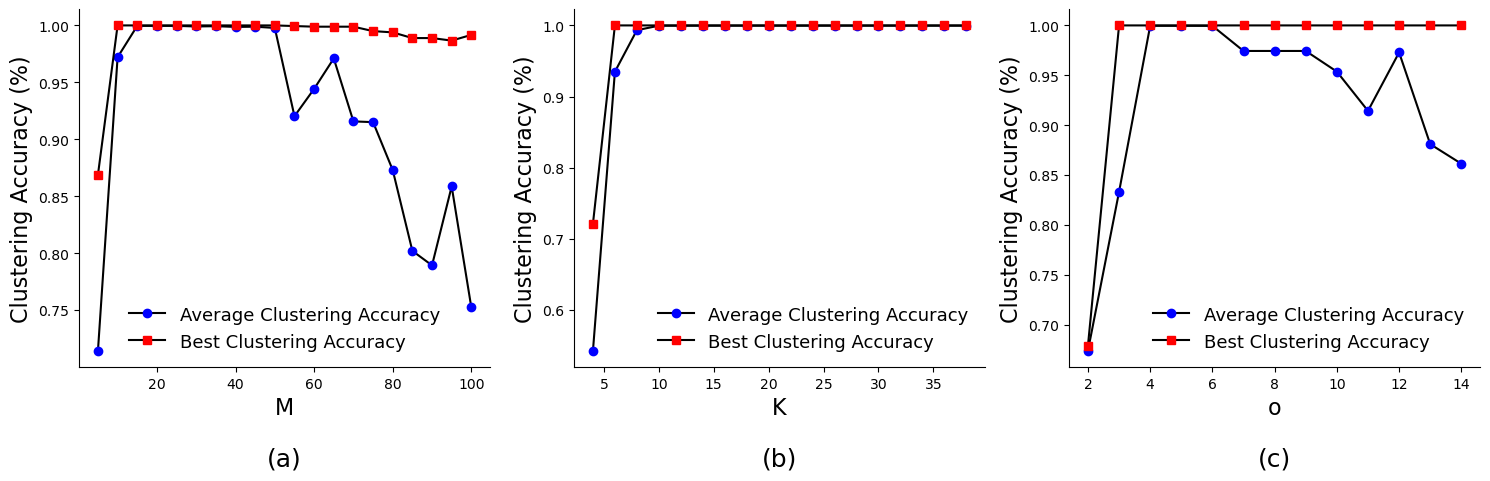

In [20]:
hyperparam_list = ['M','K','o']
x_list = [np.arange(5,105,5),np.arange(4,40,2),np.arange(2,15,1)]
title_list = ['a','b','c']
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, ax in enumerate(axes):
    ax.plot(x_list[i], mean_acc_plot[hyperparam_list[i]], label='Average Clustering Accuracy',color = 'black',marker = 'o',markeredgecolor='blue',markerfacecolor='blue') 
    ax.plot(x_list[i], best_acc_plot[hyperparam_list[i]], label='Best Clustering Accuracy',color = 'black',marker = 's',markeredgecolor='red',markerfacecolor='red') 
    ax.set_title(f'({title_list[i]})',y = -0.3,size = 18)
    ax.set_xlabel(hyperparam_list[i],size = 16)
    ax.set_ylabel('Clustering Accuracy (%)',size = 16)
    ax.legend(frameon=False, fontsize=13) 
    ax.grid(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

plt.tight_layout()
plt.savefig("Sensitivity Analysis.png", dpi=600, bbox_inches="tight")
plt.show()